In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from scipy import signal
from scipy import sparse
from scipy.sparse.linalg import spsolve
import os
import csv

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=10)

In [2]:
image_path='C:/Users/Asus/Desktop/practical/SVD/spectrums/green_edited/'
std_data_path="C:/Users/Asus/Desktop/practical/SVD/lspdd_data/CFL_Twister_domestic-use_daylight-color_EnerSaver_Globe-brand_13W_120V_67.7Lum_5000K/"
csv_file_path='C:/Users/Asus/Desktop/practical/SVD/csv files/'
csv_file="green_edited.csv"

cali_image ="cali.jpg"
ref_image="bright.jpg"
dark_image="dark.jpg"

In [3]:
def spectrum(spec_name,show_img=0):
    im = Image.open(image_path+spec_name )
    
    if(show_img==1):
        plt.imshow(im)
        plt.show()
    
    width, height=im.size
    pix = im.load()

    x=[]
    y=[]

    for i in range(0,width):      
        s = 0.0
        for j in range(0,height):
            RGB=pix[i,j]
            s+=sum(RGB)/3                                            #avarage method
            #s+=0.21*int(RGB[0]) + 0.72*int(RGB[1]) + 0.07*int(RGB[2]) #luminosity method

        x.append(i)        
        y.append(s/height)

    y=np.array(y)   
    y=y[::-1]

    return [x,y]

In [4]:
def runall(m,c,wl,image_path=image_path):
    ref_intensity=[]
    in_array=[]
    noice=[]
    lbl=[]
    
    dir_path= os.path.dirname(image_path)
    for root, dirs, files in os.walk(dir_path):
        for file in files: 
            if file.endswith('.jpg'):
                file_name=str(file) #file_name=root+'/'+str(file)
                #print(file_name)
                get_intensity(noice,ref_intensity,in_array,file_name,m,c,lbl)
                #print("done")
                            
    ref_intensity=ref_intensity[0] 
    noice=noice[0]
    
    #intensity graphs
    plt.figure(1)
    plt.figure(figsize=(15,5))
    plt.plot(wl,ref_intensity,label="ref")
    count=0
    for i in in_array:
        plt.plot(wl,i,label=lbl[count])
        count+=1
    #plt.axhline(y=0, color='r', linestyle='-')
    plt.legend() 
    plt.xlabel("Wavelength")
    plt.ylabel("Intensity")
    plt.show()
    
    ab_array=get_absorbance(ref_intensity,noice,in_array)
    
    #absorbance graphs
    plt.figure(2)
    plt.figure(figsize=(15,5))
    count=0
    for i in ab_array:
        plt.plot(wl,i,label=lbl[count])
        count+=1
    #plt.axhline(y=0, color='r', linestyle='-')
    plt.legend(loc = "upper right") 
    plt.xlabel("wavelength")
    #plt.ylabel("Transmitance")
    plt.ylabel("$I/I_0$")
    plt.show()
    
    #plt.figure(figsize=(15,5))
    #plt.plot(wl,ab_array[0])
    #plt.show()
    #print(lbl)
    
    return ab_array,lbl
    

In [5]:
def get_intensity(noice,ref_intensity,in_array,file_name,m,c,lbl):
    
    x,intensity=spectrum(file_name)
    
    #baseline = baseline_als(intensity,4e2,0.0007)-1
    #intensity=intensity-baseline

    
    if file_name==ref_image:
        ref_intensity.append(intensity)
        
    elif  file_name==cali_image:
        return None
    elif file_name==dark_image:
        noice.append(intensity)
    else:
        lbl.append(file_name)
        in_array.append(intensity)
          

In [6]:
def get_absorbance(ref_intensity,noice,in_array):
    ab_array=[]
    for i in in_array:
        absorbance=[]
        for j in range(len(i)):
            T=(i[j]-noice[j])/(ref_intensity[j]-noice[j])
            #T=(i[j])/(ref_intensity[j])
            A=T
            absorbance.append(A)
            
        ab_array.append(absorbance)
    return  ab_array                

In [7]:
def csv_maker(ab_array,wl,con,lbl):
    
    fields = wl
    rows = []
    filename = csv_file
    
    #for i in range(len(ab_array[0])):
    #    temp=[]
    #    for j in range(len(ab_array)):
    #        temp.append(ab_array[j][i])
    #    rows.append(temp)    
    #print(rows)
    rows=[]
    
    for i in range(len(con)):
        for j in range(len(lbl)):
            if (str(con[i])+'.jpg')==lbl[j]:
                #print(lbl[j]+' and '+str(con[i]) )
                rows.append(ab_array[j])
                break    
    
    plt.figure(figsize=(15,5))
    for k in range(len(rows)):
        plt.plot(rows[k])
    plt.legend()
    plt.show()
        
    
         
   
    
    with open(csv_file_path+filename, 'w',newline='') as csvfile:
        # creating a csv writer object
        csvwriter = csv.writer(csvfile)
      
        # writing the fields
        #csvwriter.writerow(fields)
      
        # writing the data rows
        csvwriter.writerows(rows)
        
        
    print("csv file is created...")      

In [8]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

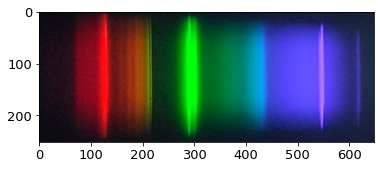

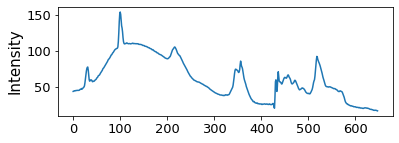

In [9]:
x,intensity=spectrum(cali_image,1)
plt.figure(figsize=(6,2))
plt.plot(x,intensity)
plt.ylabel('Intensity')
plt.show()

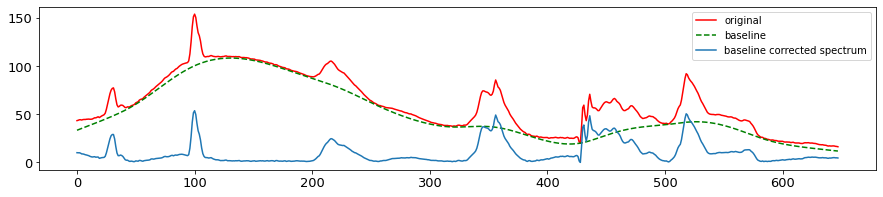

In [10]:
plt.figure(figsize=(15,3)) 
plt.plot(x,intensity,c='r',label='original')

#baseline = baseline_als(intensity,1e4,0.0005)
#baseline = baseline_als(intensity,1e2,0.008)

baseline = baseline_als(intensity,4e2,0.0007)-1
corrected_intensity=intensity-baseline


plt.plot(x,baseline,c='g', linestyle="--",label='baseline')
plt.plot(x,corrected_intensity,label='baseline corrected spectrum')
plt.legend()
plt.show()

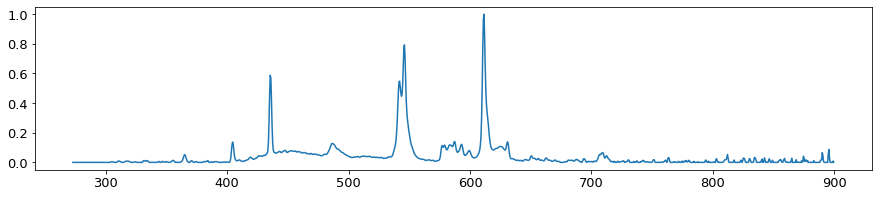

In [11]:
file_name="CFL_Twister_domestic-use_daylight-color_EnerSaver_Globe-brand_13W_120V_67.7Lum_5000K.csv"

df = pd.read_csv(std_data_path+file_name)
data = df.to_numpy()

std_wl=np.array(data[:,0])
std_in=np.array(data[:,1])
std_in=std_in/max(std_in)

plt.figure(figsize=(15,3))
plt.plot(std_wl,std_in)
plt.show()

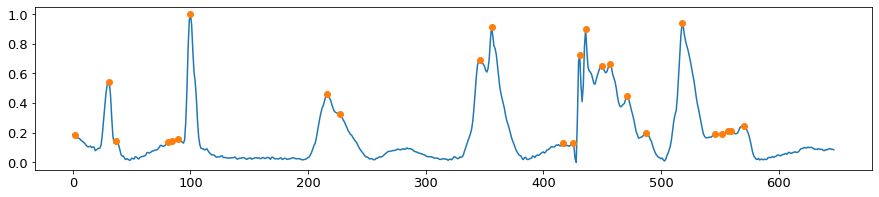

<Figure size 432x288 with 0 Axes>

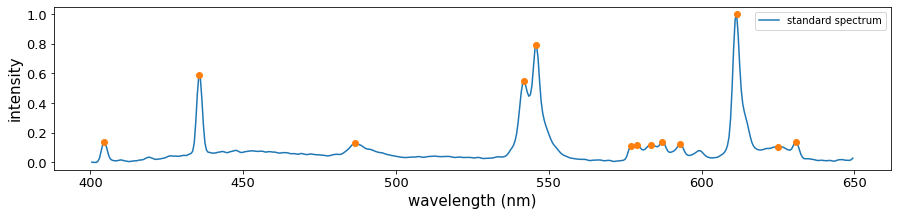

[  2  31  37  81  84  89 100 216 227 346 356 417 425 431 436 450 457 471
 487 518 546 552 557 560 571]
[  8  70 172 283 291 353 357 366 373 385 422 449 461]


In [12]:
intensity=corrected_intensity/max(corrected_intensity)

cutoff_up=650
cutoff_down=400

up_cutoff_index=max(np.where(std_wl<cutoff_up)[0])
down_cutoff_index=min(np.where(std_wl>cutoff_down)[0])

c_std_wl=std_wl[down_cutoff_index:up_cutoff_index+1]
c_std_in=std_in[down_cutoff_index:up_cutoff_index+1]

spec_peaks,_=signal.find_peaks(intensity,height=0.12)
std_peaks,_=signal.find_peaks(c_std_in,height=0.1)


plt.figure(figsize=(15,3))
plt.figure(1)
plt.plot(x,intensity,label='experimental')
plt.plot(spec_peaks, intensity[spec_peaks] ,"o")
#plt.axhline(y=0, color='r', linestyle='-')
plt.show()

plt.figure(2)
plt.figure(figsize=(15,3))
plt.plot(c_std_wl,c_std_in,label='standard spectrum')
plt.plot(c_std_wl[std_peaks], c_std_in[std_peaks] ,"o")
plt.xlabel("wavelength (nm)")
plt.ylabel("intensity")
plt.legend()
plt.show()

print(spec_peaks)
print(std_peaks)

In [13]:
#blue 2
#del_spec_peaks=[0,1,6,7,8,9,10]     
#del_std_peaks=[0,5,6,7,8,9,11,12]

#green ed
del_spec_peaks=[0,2,3,4,5,8,11,12,13,14,15,16,17,18,20,21,22,23,24] 
del_std_peaks=[5,6,7,8,9,11,12]

#red ed
#del_spec_peaks=[1,2,3,4,5,8,11,12,13,14,15,16,17,19,20,21,22,23,24] 
#del_std_peaks=[5,6,7,8,9,11,12]

#blue_ed/ red_ed2
#del_spec_peaks=[3,6,7,8,9,10,11,13,14] 
#del_std_peaks=[5,6,7,8,9,11,12]

#milk
#del_spec_peaks=[0,2,3,6,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25] 
#del_std_peaks=[5,6,7,8,9,11]

#solid
#del_spec_peaks=[2,5,6,7] 
#del_std_peaks=[0,5,6,7,8,9,11,12]


new_spec_peaks=np.delete(spec_peaks,del_spec_peaks)
new_std_peaks=np.delete(std_peaks,del_std_peaks)

print(new_spec_peaks)
print(new_std_peaks)

[ 31 100 216 346 356 518]
[  8  70 172 283 291 422]


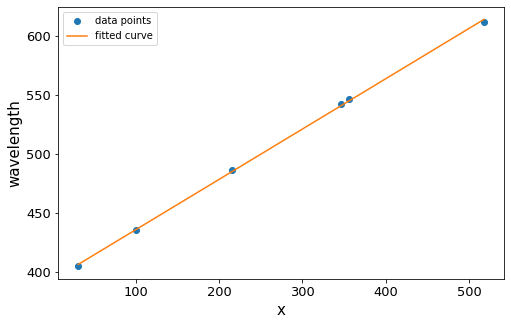

[0.4262970836751395, 392.9987449801761]


In [14]:
coeff= np.polyfit(new_spec_peaks,c_std_wl[new_std_peaks], 1)

ffit = np.poly1d(coeff)

m,c =coeff
plt.figure(figsize=(8,5))
plt.plot(new_spec_peaks,c_std_wl[new_std_peaks],'o',label='data points')

plt.plot(new_spec_peaks, ffit(new_spec_peaks),label='fitted curve')

plt.ylabel('wavelength')
plt.xlabel('x')
plt.legend()
plt.show()

print([m,c])

In [15]:
wl=[]
for i in x:
    wl.append(i*m+c)

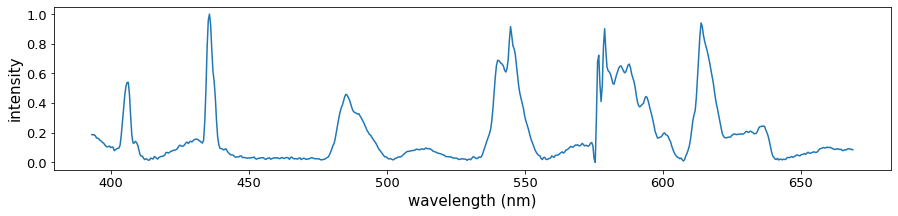

In [16]:
plt.figure(figsize=(15,3))
plt.plot(wl,intensity)
plt.xlabel("wavelength (nm)")
plt.ylabel("intensity")
plt.show()

<Figure size 432x288 with 0 Axes>

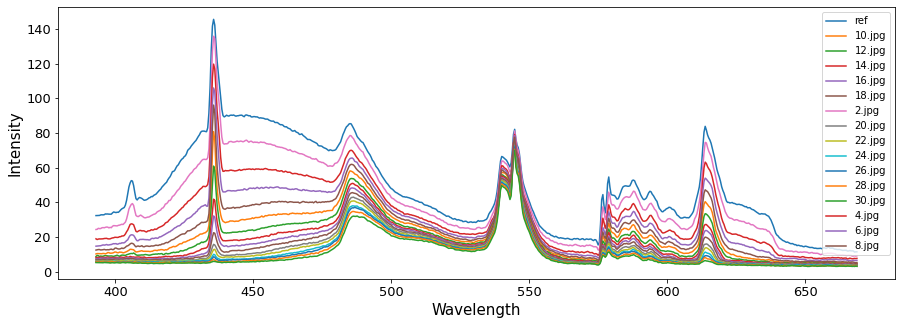

<Figure size 432x288 with 0 Axes>

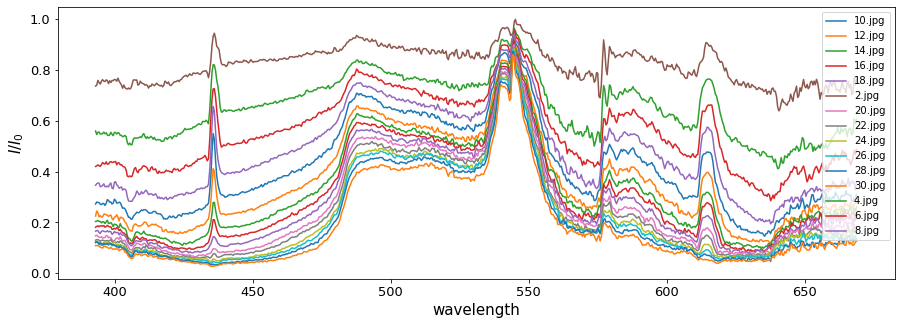

['10.jpg', '12.jpg', '14.jpg', '16.jpg', '18.jpg', '2.jpg', '20.jpg', '22.jpg', '24.jpg', '26.jpg', '28.jpg', '30.jpg', '4.jpg', '6.jpg', '8.jpg']


In [17]:
con=[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]
#con=[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
#con=[1,2,3,4,5,6,7,8]
ab_array,lbl=runall(m,c,wl)
print(lbl)
#csv_maker(ab_array,wl,con,lbl)


#print(ab_array)
